In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-tools/pycatch22-0.4.2.tar.gz
/kaggle/input/time-series-tools/multiprocess-0.70.14-py37-none-any.whl
/kaggle/input/time-series-tools/tsflex-0.3.0-py3-none-any.whl
/kaggle/input/time-series-tools/joblib-1.2.0-py3-none-any.whl
/kaggle/input/time-series-tools/scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/time-series-tools/six-1.16.0-py2.py3-none-any.whl
/kaggle/input/time-series-tools/__results__.html
/kaggle/input/time-series-tools/threadpoolctl-3.1.0-py3-none-any.whl
/kaggle/input/time-series-tools/python_dateutil-2.8.2-py2.py3-none-any.whl
/kaggle/input/time-series-tools/pytz-2022.7.1-py2.py3-none-any.whl
/kaggle/input/time-series-tools/tqdm-4.65.0-py3-none-any.whl
/kaggle/input/time-series-tools/dill-0.3.6-py3-none-any.whl
/kaggle/input/time-series-tools/__notebook__.ipynb
/kaggle/input/time-series-tools/scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
/kaggle/input/time-series-tools/pandas-1.3.

In [2]:
!pip install tsflex --no-index --find-links=file:///kaggle/input/time-series-tools
!pip install seglearn --no-index --find-links=file:///kaggle/input/time-series-tools

Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/tsflex-0.3.0-py3-none-any.whl
Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/seglearn-1.2.5-py3-none-any.whl


In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob

p = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'

train = glob.glob(p+'train/**/**')
test = glob.glob(p+'test/**/**')
subjects = pd.read_csv(p+'subjects.csv')
tasks = pd.read_csv(p+'tasks.csv')
sub = pd.read_csv(p+'sample_submission.csv')

tdcsfog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
defog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
tdcsfog_metadata['Module']='tdcsfog'
defog_metadata['Module']='defog'
metadata=pd.concat([tdcsfog_metadata,defog_metadata])

In [4]:
tasks['Duration'] = tasks['End'] - tasks['Begin']
tasks = pd.pivot_table(tasks, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
tasks.columns = [c[-1] for c in tasks.columns]
tasks = tasks.reset_index()
tasks['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(tasks[tasks.columns[1:]])

subjects = subjects.fillna(0).groupby('Subject').median()
subjects = subjects.reset_index()
subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
subjects=subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})

In [5]:
complex_featlist=['Visit','Test','Medication','s_Visit','s_Age','s_YearsSinceDx','s_UPDRSIII_On','s_UPDRSIII_Off','s_NFOGQ','s_kmeans']
metadata_complex=metadata.merge(subjects,how='left',on='Subject').copy()
metadata_complex['Medication']=metadata_complex['Medication'].factorize()[0]

In [6]:
from seglearn.feature_functions import base_features, emg_features

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper


basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

fc = FeatureCollection([basic_feats, emg_feats])

In [7]:
import pathlib
def reader(f):
    try:
        df = pd.read_csv(f, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])
        
        df['Id'] = f.split('/')[-1].split('.')[0]
        df['Module'] = pathlib.Path(f).parts[-2]
        
        df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
        
        df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
#         df = pd.merge(df, subjects[['Id','s_kmeans']], how='left', on='Id').fillna(-1)
        df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        df = df.merge(df_feats, how="left", left_index=True, right_index=True)
        df.fillna(method="ffill", inplace=True)
        return df
    except: pass
train = pd.concat([reader(f) for f in tqdm(train)]).fillna(0); print(train.shape)
cols = [c for c in train.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]
pcols = ['StartHesitation', 'Turn' , 'Walking']
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']

  0%|          | 0/970 [00:00<?, ?it/s]

(20588374, 72)


In [8]:
train=train.reset_index(drop=True)

<AxesSubplot:>

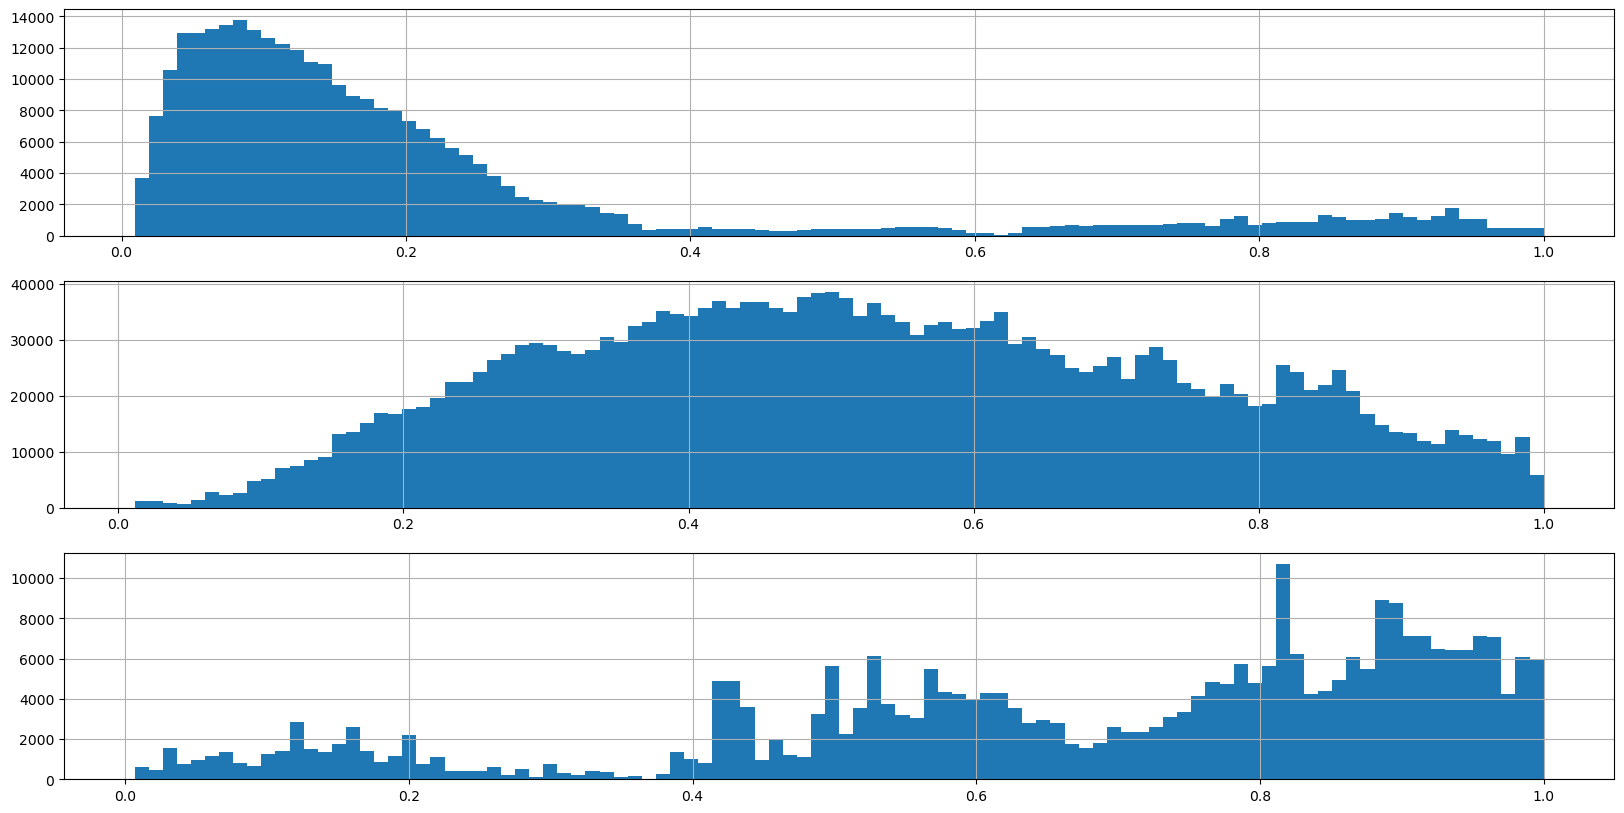

In [9]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(3,1,figsize=(20,10))
train.loc[train['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100)
train.loc[train['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100)
train.loc[train['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100)

In [10]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer

best_params_ = {'estimator__colsample_bytree': 0.5292057895135501, 
 'estimator__learning_rate': 0.22959963168004743, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1433911067827616, 
 'estimator__n_estimators': 291, 
 'estimator__subsample': 0.9991057796456088}

In [12]:
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [13]:
from sklearn.base import clone

def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True

class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]
        
        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params)
        
        return self

In [14]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values #2000000
    
    
    base_regressor = lgb.LGBMRegressor(**best_params_)

    
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=25
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0578761	valid_0's average_precision: 0.130233
[2]	valid_0's l2: 0.0568294	valid_0's average_precision: 0.360881
[3]	valid_0's l2: 0.0568845	valid_0's average_precision: 0.32333
[4]	valid_0's l2: 0.0569649	valid_0's average_precision: 0.236865
[5]	valid_0's l2: 0.056553	valid_0's average_precision: 0.292221
[6]	valid_0's l2: 0.0563658	valid_0's average_precision: 0.291794
[7]	valid_0's l2: 0.0564397	valid_0's average_precision: 0.280908
[8]	valid_0's l2: 0.0564598	valid_0's average_precision: 0.268219
[9]	valid_0's l2: 0.0565094	valid_0's average_precision: 0.238013
[10]	valid_0's l2: 0.0565546	valid_0's average_precision: 0.225463
[11]	valid_0's l2: 0.0565595	valid_0's average_precision: 0.202397
[12]	valid_0's l2: 0.0565564	valid_0's average_precision: 0.200111
[13]	valid_0's l2: 0.0565601	valid_0's average_precision: 0.200694
[14]	valid_0's l2: 0.0565601	valid_0's average_precision: 0.198126
[15]	valid_0's l2: 0.056603	valid_0's average_precision: 0.191989
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.192504	valid_0's average_precision: 0.401311
[2]	valid_0's l2: 0.18304	valid_0's average_precision: 0.45627
[3]	valid_0's l2: 0.17446	valid_0's average_precision: 0.49536
[4]	valid_0's l2: 0.169354	valid_0's average_precision: 0.544832
[5]	valid_0's l2: 0.1651	valid_0's average_precision: 0.561372
[6]	valid_0's l2: 0.163972	valid_0's average_precision: 0.545607
[7]	valid_0's l2: 0.157204	valid_0's average_precision: 0.583931
[8]	valid_0's l2: 0.158825	valid_0's average_precision: 0.564625
[9]	valid_0's l2: 0.158837	valid_0's average_precision: 0.562625
[10]	valid_0's l2: 0.154891	valid_0's average_precision: 0.576565
[11]	valid_0's l2: 0.150737	valid_0's average_precision: 0.594558
[12]	valid_0's l2: 0.149617	valid_0's average_precision: 0.594284
[13]	valid_0's l2: 0.146475	valid_0's average_precision: 0.609718
[14]	valid_0's l2: 0.146455	valid_0's average_precision: 0.610477
[15]	valid_0's l2: 0.143326	valid_0's average_precision: 0.625231
[16]	valid_0's l2: 0.1419

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0351986	valid_0's average_precision: 0.0906403
[2]	valid_0's l2: 0.0352026	valid_0's average_precision: 0.0976227
[3]	valid_0's l2: 0.035282	valid_0's average_precision: 0.109936
[4]	valid_0's l2: 0.0379943	valid_0's average_precision: 0.0749546
[5]	valid_0's l2: 0.0380664	valid_0's average_precision: 0.0772898
[6]	valid_0's l2: 0.0402168	valid_0's average_precision: 0.0877618
[7]	valid_0's l2: 0.0401044	valid_0's average_precision: 0.103878
[8]	valid_0's l2: 0.0401768	valid_0's average_precision: 0.106324
[9]	valid_0's l2: 0.0402597	valid_0's average_precision: 0.0999132
[10]	valid_0's l2: 0.0404304	valid_0's average_precision: 0.108003
[11]	valid_0's l2: 0.0407058	valid_0's average_precision: 0.110638
[12]	valid_0's l2: 0.0408081	valid_0's average_precision: 0.111937
[13]	valid_0's l2: 0.0409027	valid_0's average_precision: 0.110365
[14]	valid_0's l2: 0.0406346	valid_0's average_precision: 0.108497
[15]	valid_0's l2: 0.0407459	valid_0's average_precision: 0.096798

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00866478	valid_0's average_precision: 0.00855808
[2]	valid_0's l2: 0.00869434	valid_0's average_precision: 0.00853803
[3]	valid_0's l2: 0.00879157	valid_0's average_precision: 0.0346622
[4]	valid_0's l2: 0.00879563	valid_0's average_precision: 0.030613
[5]	valid_0's l2: 0.00880657	valid_0's average_precision: 0.0358248
[6]	valid_0's l2: 0.00882588	valid_0's average_precision: 0.0372702
[7]	valid_0's l2: 0.00891236	valid_0's average_precision: 0.0455394
[8]	valid_0's l2: 0.00904261	valid_0's average_precision: 0.0594504
[9]	valid_0's l2: 0.00906913	valid_0's average_precision: 0.0657599
[10]	valid_0's l2: 0.00921547	valid_0's average_precision: 0.0645666
[11]	valid_0's l2: 0.00921382	valid_0's average_precision: 0.0646509
[12]	valid_0's l2: 0.00922733	valid_0's average_precision: 0.0626297
[13]	valid_0's l2: 0.00923696	valid_0's average_precision: 0.064834
[14]	valid_0's l2: 0.00942982	valid_0's average_precision: 0.0682051
[15]	valid_0's l2: 0.00943382	valid_0's ave

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.094101	valid_0's average_precision: 0.456928
[2]	valid_0's l2: 0.0854855	valid_0's average_precision: 0.515838
[3]	valid_0's l2: 0.0846465	valid_0's average_precision: 0.526624
[4]	valid_0's l2: 0.0799413	valid_0's average_precision: 0.562901
[5]	valid_0's l2: 0.078779	valid_0's average_precision: 0.55105
[6]	valid_0's l2: 0.0779404	valid_0's average_precision: 0.555244
[7]	valid_0's l2: 0.0775253	valid_0's average_precision: 0.55059
[8]	valid_0's l2: 0.0768305	valid_0's average_precision: 0.554512
[9]	valid_0's l2: 0.0769627	valid_0's average_precision: 0.552823
[10]	valid_0's l2: 0.0766407	valid_0's average_precision: 0.547291
[11]	valid_0's l2: 0.0768182	valid_0's average_precision: 0.541484
[12]	valid_0's l2: 0.0766714	valid_0's average_precision: 0.544145
[13]	valid_0's l2: 0.0770307	valid_0's average_precision: 0.535323
[14]	valid_0's l2: 0.0766521	valid_0's average_precision: 0.537629
[15]	valid_0's l2: 0.0767087	valid_0's average_precision: 0.532047
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00448928	valid_0's average_precision: 0.00435039
[2]	valid_0's l2: 0.00579757	valid_0's average_precision: 0.00726061
[3]	valid_0's l2: 0.00598932	valid_0's average_precision: 0.00623139
[4]	valid_0's l2: 0.00594267	valid_0's average_precision: 0.00962507
[5]	valid_0's l2: 0.00594699	valid_0's average_precision: 0.0113761
[6]	valid_0's l2: 0.00596403	valid_0's average_precision: 0.0115298
[7]	valid_0's l2: 0.00614113	valid_0's average_precision: 0.0110867
[8]	valid_0's l2: 0.00616046	valid_0's average_precision: 0.0100735
[9]	valid_0's l2: 0.00643288	valid_0's average_precision: 0.0102761
[10]	valid_0's l2: 0.0064312	valid_0's average_precision: 0.00907567
[11]	valid_0's l2: 0.00663439	valid_0's average_precision: 0.00881963
[12]	valid_0's l2: 0.00662139	valid_0's average_precision: 0.00947896
[13]	valid_0's l2: 0.00670485	valid_0's average_precision: 0.00966725
[14]	valid_0's l2: 0.00670655	valid_0's average_precision: 0.00948739
[15]	valid_0's l2: 0.00670331	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00136583	valid_0's average_precision: 0.000849382
[2]	valid_0's l2: 0.00157551	valid_0's average_precision: 0.00535368
[3]	valid_0's l2: 0.00176848	valid_0's average_precision: 0.0116093
[4]	valid_0's l2: 0.00207522	valid_0's average_precision: 0.00591549
[5]	valid_0's l2: 0.00200577	valid_0's average_precision: 0.0114264
[6]	valid_0's l2: 0.00199964	valid_0's average_precision: 0.0142905
[7]	valid_0's l2: 0.0019973	valid_0's average_precision: 0.0163641
[8]	valid_0's l2: 0.00211229	valid_0's average_precision: 0.0167272
[9]	valid_0's l2: 0.00218491	valid_0's average_precision: 0.0165014
[10]	valid_0's l2: 0.00218696	valid_0's average_precision: 0.0164054
[11]	valid_0's l2: 0.00222433	valid_0's average_precision: 0.0173433
[12]	valid_0's l2: 0.00237934	valid_0's average_precision: 0.0162966
[13]	valid_0's l2: 0.00237916	valid_0's average_precision: 0.0166923
[14]	valid_0's l2: 0.00243469	valid_0's average_precision: 0.0168263
[15]	valid_0's l2: 0.00242231	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0609061	valid_0's average_precision: 0.1187
[2]	valid_0's l2: 0.0595097	valid_0's average_precision: 0.133603
[3]	valid_0's l2: 0.0587421	valid_0's average_precision: 0.135281
[4]	valid_0's l2: 0.0583972	valid_0's average_precision: 0.153489
[5]	valid_0's l2: 0.0580815	valid_0's average_precision: 0.165915
[6]	valid_0's l2: 0.0577864	valid_0's average_precision: 0.175345
[7]	valid_0's l2: 0.0576345	valid_0's average_precision: 0.178892
[8]	valid_0's l2: 0.0578315	valid_0's average_precision: 0.173831
[9]	valid_0's l2: 0.0577978	valid_0's average_precision: 0.176001
[10]	valid_0's l2: 0.0578172	valid_0's average_precision: 0.175614
[11]	valid_0's l2: 0.0575962	valid_0's average_precision: 0.17956
[12]	valid_0's l2: 0.057457	valid_0's average_precision: 0.183597
[13]	valid_0's l2: 0.0569275	valid_0's average_precision: 0.192967
[14]	valid_0's l2: 0.0571218	valid_0's average_precision: 0.190759
[15]	valid_0's l2: 0.0568867	valid_0's average_precision: 0.198581
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00187972	valid_0's average_precision: 0.00168002
[2]	valid_0's l2: 0.00196354	valid_0's average_precision: 0.00236058
[3]	valid_0's l2: 0.00200281	valid_0's average_precision: 0.00189589
[4]	valid_0's l2: 0.00197523	valid_0's average_precision: 0.00206574
[5]	valid_0's l2: 0.00205644	valid_0's average_precision: 0.00420605
[6]	valid_0's l2: 0.00229973	valid_0's average_precision: 0.00393814
[7]	valid_0's l2: 0.00229373	valid_0's average_precision: 0.00366349
[8]	valid_0's l2: 0.00231615	valid_0's average_precision: 0.00428819
[9]	valid_0's l2: 0.00242676	valid_0's average_precision: 0.00464986
[10]	valid_0's l2: 0.00265592	valid_0's average_precision: 0.00451046
[11]	valid_0's l2: 0.00297773	valid_0's average_precision: 0.00433667
[12]	valid_0's l2: 0.00305988	valid_0's average_precision: 0.00398919
[13]	valid_0's l2: 0.00304024	valid_0's average_precision: 0.00426621
[14]	valid_0's l2: 0.00305754	valid_0's average_precision: 0.00420386
[15]	valid_0's l2: 0.00306814

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00600727	valid_0's average_precision: 0.00707307
[2]	valid_0's l2: 0.00602529	valid_0's average_precision: 0.0159298
[3]	valid_0's l2: 0.00604047	valid_0's average_precision: 0.0138193
[4]	valid_0's l2: 0.00606633	valid_0's average_precision: 0.0134232
[5]	valid_0's l2: 0.00602164	valid_0's average_precision: 0.0174621
[6]	valid_0's l2: 0.00606058	valid_0's average_precision: 0.0286694
[7]	valid_0's l2: 0.00605652	valid_0's average_precision: 0.0289778
[8]	valid_0's l2: 0.00606924	valid_0's average_precision: 0.0306281
[9]	valid_0's l2: 0.00607076	valid_0's average_precision: 0.0303446
[10]	valid_0's l2: 0.0061427	valid_0's average_precision: 0.0289129
[11]	valid_0's l2: 0.00614753	valid_0's average_precision: 0.0283607
[12]	valid_0's l2: 0.0061592	valid_0's average_precision: 0.0297161
[13]	valid_0's l2: 0.00616048	valid_0's average_precision: 0.0293277
[14]	valid_0's l2: 0.00616814	valid_0's average_precision: 0.028027
[15]	valid_0's l2: 0.00615157	valid_0's avera

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0735906	valid_0's average_precision: 0.335534
[2]	valid_0's l2: 0.0691837	valid_0's average_precision: 0.386624
[3]	valid_0's l2: 0.0675228	valid_0's average_precision: 0.403593
[4]	valid_0's l2: 0.0663558	valid_0's average_precision: 0.395289
[5]	valid_0's l2: 0.0655047	valid_0's average_precision: 0.396526
[6]	valid_0's l2: 0.0656359	valid_0's average_precision: 0.397246
[7]	valid_0's l2: 0.0650117	valid_0's average_precision: 0.404691
[8]	valid_0's l2: 0.0645112	valid_0's average_precision: 0.406512
[9]	valid_0's l2: 0.0642138	valid_0's average_precision: 0.415298
[10]	valid_0's l2: 0.0642519	valid_0's average_precision: 0.416474
[11]	valid_0's l2: 0.0642299	valid_0's average_precision: 0.408249
[12]	valid_0's l2: 0.0639801	valid_0's average_precision: 0.419734
[13]	valid_0's l2: 0.0638207	valid_0's average_precision: 0.422368
[14]	valid_0's l2: 0.0640539	valid_0's average_precision: 0.417306
[15]	valid_0's l2: 0.0639106	valid_0's average_precision: 0.420898
[16]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0258316	valid_0's average_precision: 0.0269351
[2]	valid_0's l2: 0.0258707	valid_0's average_precision: 0.031453
[3]	valid_0's l2: 0.0259291	valid_0's average_precision: 0.0309298
[4]	valid_0's l2: 0.0259808	valid_0's average_precision: 0.0315085
[5]	valid_0's l2: 0.0260106	valid_0's average_precision: 0.0313852
[6]	valid_0's l2: 0.0260278	valid_0's average_precision: 0.0306277
[7]	valid_0's l2: 0.0260513	valid_0's average_precision: 0.032889
[8]	valid_0's l2: 0.0260971	valid_0's average_precision: 0.0326091
[9]	valid_0's l2: 0.0261663	valid_0's average_precision: 0.0301991
[10]	valid_0's l2: 0.0261836	valid_0's average_precision: 0.0304772
[11]	valid_0's l2: 0.0262757	valid_0's average_precision: 0.0338032
[12]	valid_0's l2: 0.0262833	valid_0's average_precision: 0.0341361
[13]	valid_0's l2: 0.0262803	valid_0's average_precision: 0.0345273
[14]	valid_0's l2: 0.0262841	valid_0's average_precision: 0.0348679
[15]	valid_0's l2: 0.0262857	valid_0's average_precision: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.000654198	valid_0's average_precision: 0.00044468
[2]	valid_0's l2: 0.00061089	valid_0's average_precision: 0.0034996
[3]	valid_0's l2: 0.000729909	valid_0's average_precision: 0.00201993
[4]	valid_0's l2: 0.000827888	valid_0's average_precision: 0.00193567
[5]	valid_0's l2: 0.000858117	valid_0's average_precision: 0.00352645
[6]	valid_0's l2: 0.000876514	valid_0's average_precision: 0.00352811
[7]	valid_0's l2: 0.000950813	valid_0's average_precision: 0.00375644
[8]	valid_0's l2: 0.00103134	valid_0's average_precision: 0.00375735
[9]	valid_0's l2: 0.00106872	valid_0's average_precision: 0.00376896
[10]	valid_0's l2: 0.0010779	valid_0's average_precision: 0.0036406
[11]	valid_0's l2: 0.00107475	valid_0's average_precision: 0.00338088
[12]	valid_0's l2: 0.00107687	valid_0's average_precision: 0.00334054
[13]	valid_0's l2: 0.00107539	valid_0's average_precision: 0.00343607
[14]	valid_0's l2: 0.00108195	valid_0's average_precision: 0.00339471
[15]	valid_0's l2: 0.00109

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0481949	valid_0's average_precision: 0.122564
[2]	valid_0's l2: 0.0465522	valid_0's average_precision: 0.128019
[3]	valid_0's l2: 0.0461982	valid_0's average_precision: 0.12397
[4]	valid_0's l2: 0.045805	valid_0's average_precision: 0.128952
[5]	valid_0's l2: 0.0454379	valid_0's average_precision: 0.13973
[6]	valid_0's l2: 0.0452599	valid_0's average_precision: 0.140514
[7]	valid_0's l2: 0.0440549	valid_0's average_precision: 0.164535
[8]	valid_0's l2: 0.0437348	valid_0's average_precision: 0.17048
[9]	valid_0's l2: 0.0433235	valid_0's average_precision: 0.1906
[10]	valid_0's l2: 0.0434122	valid_0's average_precision: 0.19034
[11]	valid_0's l2: 0.0434508	valid_0's average_precision: 0.192568
[12]	valid_0's l2: 0.0436703	valid_0's average_precision: 0.191204
[13]	valid_0's l2: 0.043916	valid_0's average_precision: 0.187988
[14]	valid_0's l2: 0.0439171	valid_0's average_precision: 0.190744
[15]	valid_0's l2: 0.0439065	valid_0's average_precision: 0.192421
[16]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0043842	valid_0's average_precision: 0.00385485
[2]	valid_0's l2: 0.00433826	valid_0's average_precision: 0.00424554
[3]	valid_0's l2: 0.00437974	valid_0's average_precision: 0.0060113
[4]	valid_0's l2: 0.00440357	valid_0's average_precision: 0.00585818
[5]	valid_0's l2: 0.0043916	valid_0's average_precision: 0.00574669
[6]	valid_0's l2: 0.00439112	valid_0's average_precision: 0.00538024
[7]	valid_0's l2: 0.00439763	valid_0's average_precision: 0.00537427
[8]	valid_0's l2: 0.00444533	valid_0's average_precision: 0.00739463
[9]	valid_0's l2: 0.00449805	valid_0's average_precision: 0.00717611
[10]	valid_0's l2: 0.0044931	valid_0's average_precision: 0.00726183
[11]	valid_0's l2: 0.00449087	valid_0's average_precision: 0.00707995
[12]	valid_0's l2: 0.00456587	valid_0's average_precision: 0.00701047
[13]	valid_0's l2: 0.00456979	valid_0's average_precision: 0.00697249
[14]	valid_0's l2: 0.00459945	valid_0's average_precision: 0.00653543
[15]	valid_0's l2: 0.00462186	val

In [15]:
sub['t'] = 0
submission = []
for f in test:
    df = pd.read_csv(f)
    df.set_index('Time', drop=True, inplace=True)

    df['Id'] = f.split('/')[-1].split('.')[0]
    df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
    df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
    df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
    df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = df.merge(df_feats, how="left", left_index=True, right_index=True)
    df.fillna(method="ffill", inplace=True)
    
    res_vals=[]
    for i_fold in range(N_FOLDS):
        res_val=np.round(regs[i_fold].predict(df[cols]).clip(0.0,1.0),3)
        res_vals.append(np.expand_dims(res_val,axis=2))
    res_vals=np.mean(np.concatenate(res_vals,axis=2),axis=2)
    res = pd.DataFrame(res_vals, columns=pcols)
    
    df = pd.concat([df,res], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    submission.append(df[scols])
submission = pd.concat(submission)
submission = pd.merge(sub[['Id']], submission, how='left', on='Id').fillna(0.0)
submission[scols].to_csv('submission.csv', index=False)